# Checkpoint
## ARIMA utilizados en Sistema de Monitoreo de Agua de una mina

El algoritmo a utilizar es poder aplicar los conocimientos adquiridos, tomando en cuenta la parte de un análisis para los modelos de series de tiempo, este análisis se hará con modelos ARIMA aplicados a los datos de el sistema de monitoreo.

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.arima_model import ARIMA

from pymongo import MongoClient
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.signal import find_peaks
from scipy.signal import argrelextrema
import math
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sktime.forecasting.arima import AutoARIMA
from dotenv import dotenv_values

plt.style.use('ggplot')

## URL de mongodb
URL de acceso a la base de datos.

In [16]:
config_var = list(dotenv_values(".env").items())
if (len(config_var) > 0):
    URL = config_var[0][1]
    DB_REAL = 'mina'
else:
    URL = "mongodb://localhost:27017"
    DB_REAL = 'databasetest'

## read_mongo
inputs:
    collection: nombre de la colección
    pipline: pipline para hacer la consulta

In [17]:
def read_mongo(collection, pipeline):
    """ Read from Mongo and Store into DataFrame """
    # Connect to MongoDB
    client = MongoClient(URL)
    # Make a query to the specific DB and Collection
    result = client['antapaccay'][collection].aggregate(pipeline)
    client.close()
    list_result = list(result)
    #print(list_result)
    #list_result = list_result[0]['datos']['result']
    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list_result)

    return df

## getDFGlobal

In [24]:
def getDFGlobal(sitio, collection, fechalec, intrv,str_f):
    horas = int(intrv)*3
    pipline = genQueryLec(sitio, fechalec, horas,str_f)
    df_concat = pd.DataFrame(read_mongo(collection, pipline))
    #print(f'DF = {df_concat.head()}')
    return df_concat

In [22]:
def genQueryLec(sitio='SA42',
                fecha=datetime.datetime(
                    2021, 1, 1, 0, 0, 0, tzinfo=datetime.timezone.utc),
                horas=1,str_fch = 'fechalectura'):
    intr_fch = {
        '$gte': fecha - datetime.timedelta(hours=horas),
        '$lte': fecha
    }
    match_dict = {'idSitio': sitio}
    match_dict[str_fch] = intr_fch
    Rquery = [
        {
            '$match': match_dict
        }
    ]
    return Rquery

## Aqui se selecciona un sitio de la base de pruebas
el sitio se elige
fechalec = Es la hora donde se quiere analizar el modelo
Intervalo = Son las horas hacía atrás para poder hacer el análisis.
coleccion = coleccion dentro de mongo donde ese encuentrán las lecturas
str_f = string par identificar la varibale donde tiene los datos de fecha


In [148]:
sitio= 'SA88'
fechalec = datetime.datetime(2021, 7, 9, 0, 0, 0, tzinfo=datetime.timezone.utc)
intervalo = 12
coleccion = 'lecturas2gs'
str_f = 'fechalectura'
globalDF = getDFGlobal(sitio,coleccion,fechalec,intervalo,str_f)

## Ver los datos obtenidos.
Analizamos los datos de salida de cota_1, para analizar.

In [149]:
globalDF[['cota_1',str_f]].head()

,cota_1,fechalectura
0,3774.986214,2021-07-07 12:00:00
1,3786.119178,2021-07-07 12:15:00
2,3794.300343,2021-07-07 12:30:00
3,3797.579091,2021-07-07 12:45:00
4,3798.392329,2021-07-07 13:00:00


## Analizando los datos básicos 

Para poder visualizar los datos más importantes.
Datos para estandarizarlo.

   count          mean       std       min       25%       50%       75%  \
0  145.0  2.357042e-14  1.003466 -1.000431 -0.966517 -0.465498  1.190899   

        max  
0  1.227406  


<AxesSubplot:xlabel='fechalectura'>

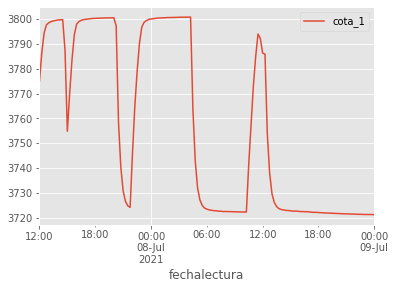

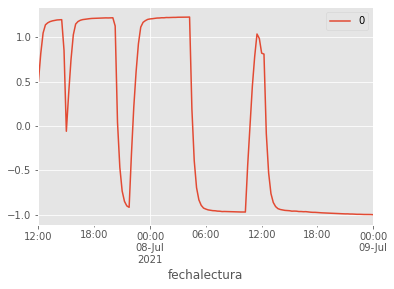

In [174]:
df = globalDF[['cota_1',str_f]]
df.set_index(str_f,inplace=True)
ss = StandardScaler()
df_ss = ss.fit_transform(df)
df_S = pd.DataFrame(df_ss)
df_S[str_f] = globalDF[str_f]
df_S.set_index(str_f,inplace=True)
print(df_S.describe().T)
df.plot()
df_S.plot()

## Obtener los datos para saber si es una señal estacionara para poder analizarlo por los datos ARIMA

In [151]:
result=adfuller(df['cota_1'])
 
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))

{'adf': -2.490331800035027,
 'pvalue': 0.11784445912808178,
 'usedlag': 1,
 'nobs': 143,
 'criticalvalues': {'1%': -3.4769274060112707,
  '5%': -2.8819726324025625,
  '10%': -2.577665408088415},
 'icbest': 837.6368509558332}

## Analizar con una diferencia para poder obtener los parametros a analizar por método ARIMA.

d:\DATA\UPIITA\BEDU Data Science\Repositorio\C1-Machine-Learning-2020\.env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


<AxesSubplot:xlabel='fechalectura'>

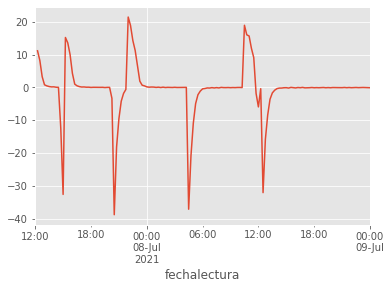

In [152]:
df['1difference']=df['cota_1']-df['cota_1'].shift(1)
 
df['1difference'].plot()

## Datos después de la modificación para poder ver si ya es posible aplicar el método ARIMA


In [153]:
result=adfuller(df['1difference'].dropna())
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))

{'adf': -6.734472259603444,
 'pvalue': 3.23364424085744e-09,
 'usedlag': 0,
 'nobs': 143,
 'criticalvalues': {'1%': -3.4769274060112707,
  '5%': -2.8819726324025625,
  '10%': -2.577665408088415},
 'icbest': 836.9631992351124}

In [154]:
df.describe()

,cota_1,cota_2,cota_3,1difference
count,145.000000,145.000000,145.000000,144.000000
mean,3757.002557,3757.764230,3799.859988,-0.372262
std,35.730089,34.879367,7.181968,8.133494
min,3721.380537,3723.014055,3792.267248,-38.611337
25%,3722.588102,3723.951832,3793.271632,-0.103398
50%,3740.427734,3739.901817,3795.029032,-0.011560
75%,3799.406486,3799.086298,3808.485822,0.092777
max,3800.706392,3800.529377,3809.188009,21.375904


## Revisar si la varible de repetitividad se cumple cada 6 horas.

d:\DATA\UPIITA\BEDU Data Science\Repositorio\C1-Machine-Learning-2020\.env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


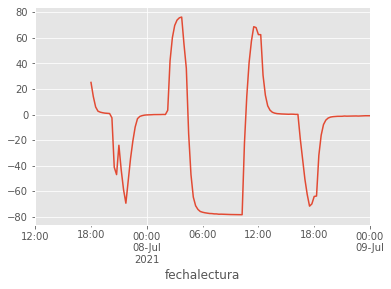

In [155]:
df['Seasonal_Difference']=df['cota_1']-df['cota_1'].shift(4*6)
ax=df['Seasonal_Difference'].plot()

In [156]:
result=adfuller((df['Seasonal_Difference']).dropna())
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))

{'adf': -3.3828652515077096,
 'pvalue': 0.011557048784786172,
 'usedlag': 1,
 'nobs': 119,
 'criticalvalues': {'1%': -3.4865346059036564,
  '5%': -2.8861509858476264,
  '10%': -2.579896092790057},
 'icbest': 781.284778689647}

## Revisar Autocorrelación y Autocorrelación parcial.

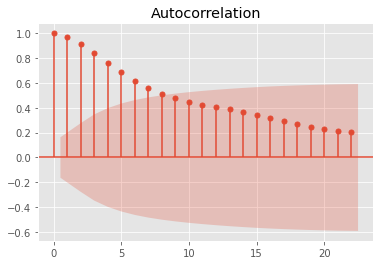

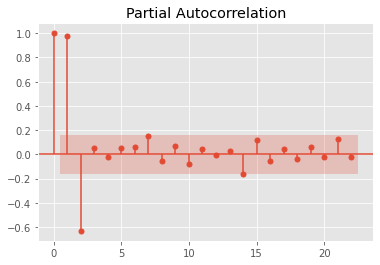

In [157]:
fig3=plot_acf(df['cota_1'].dropna()) 
fig4=plot_pacf(df['cota_1'].dropna())

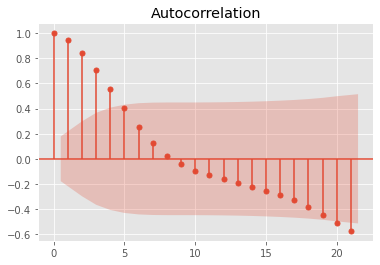

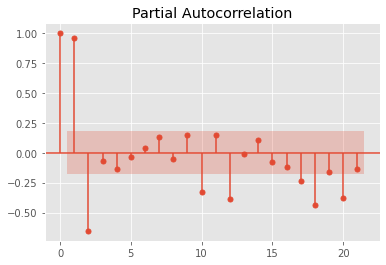

In [158]:
fig1=plot_acf(df['Seasonal_Difference'].dropna()) 
fig2=plot_pacf(df['Seasonal_Difference'].dropna())

## Aplicando modelo ARIMA con los datos calculados.

In [159]:
model=SARIMAX(df['cota_1'],order=(1,0,1),seasonal_order=(1, 0, 0, 4*6))
result=model.fit()
new_dates=[df.index[-1]+datetime.timedelta(minutes=x) for x in range(15,1500,15)]
df_pred=pd.DataFrame(index=new_dates,columns =df.columns)
df_pred.head()

d:\DATA\UPIITA\BEDU Data Science\Repositorio\C1-Machine-Learning-2020\.env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'
d:\DATA\UPIITA\BEDU Data Science\Repositorio\C1-Machine-Learning-2020\.env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  warnings.warn('No frequency information was'


,cota_1,cota_2,cota_3,1difference,Seasonal_Difference
2021-07-09 00:15:00,NaN,NaN,NaN,NaN,NaN
2021-07-09 00:30:00,NaN,NaN,NaN,NaN,NaN
2021-07-09 00:45:00,NaN,NaN,NaN,NaN,NaN
2021-07-09 01:00:00,NaN,NaN,NaN,NaN,NaN
2021-07-09 01:15:00,NaN,NaN,NaN,NaN,NaN


## Revisar salida de predicción.

<AxesSubplot:>

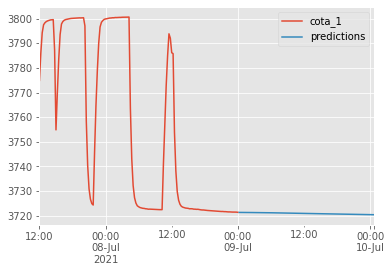

In [180]:
df2=pd.concat([df,df_pred])
df2['predictions']=result.predict(start=145,end=245)
df2[['cota_1','predictions']].plot()

## Traer datos para poder hacer la comparación con los datos reales y poder ver que tan certera es la predicción.

In [178]:
sitio= 'SA88'
fechalec = datetime.datetime(2021, 7, 10, 0, 0, 0, tzinfo=datetime.timezone.utc)
intervalo = 8
coleccion = 'lecturas2gs'
str_f = 'fechalectura'
globalDF_test = getDFGlobal(sitio,coleccion,fechalec,intervalo,str_f)

In [190]:
globalDF_test.describe()
df_test = globalDF_test[['cota_1',str_f]]
df_test.set_index(str_f,inplace=True)
df_final = pd.concat([df2,df_test])
df_final

,cota_1,cota_2,cota_3,1difference,Seasonal_Difference,predictions
2021-07-07 12:00:00,3774.986214,NaN,NaN,NaN,NaN,NaN
2021-07-07 12:15:00,3786.119178,NaN,NaN,NaN,NaN,NaN
2021-07-07 12:30:00,3794.300343,NaN,NaN,NaN,NaN,NaN
2021-07-07 12:45:00,3797.579091,NaN,NaN,NaN,NaN,NaN
2021-07-07 13:00:00,3798.392329,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2021-07-09 23:00:00,3720.864482,NaN,NaN,NaN,NaN,NaN
2021-07-09 23:15:00,3720.823965,NaN,NaN,NaN,NaN,NaN
2021-07-09 23:30:00,3720.828517,NaN,NaN,NaN,NaN,NaN
2021-07-09 23:45:00,3720.888990,NaN,NaN,NaN,NaN,NaN


## Comparación gráfica.

<AxesSubplot:>

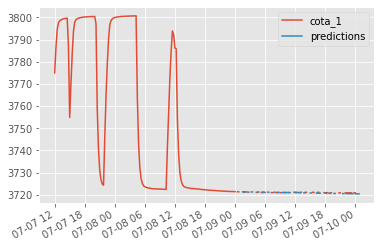

In [191]:
df_final[['cota_1','predictions']].plot()

In [202]:
model = ARIMA(df['cota_1'], order=(1,0,1))
model_fit = model.fit()

d:\DATA\UPIITA\BEDU Data Science\Repositorio\C1-Machine-Learning-2020\.env\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
d:\DATA\UPIITA\BEDU Data Science\Repositorio\C1-Machine-Learning-2020\.env\lib\site-packages\statsmodels\tsa\bas

Datos de los modelo analizado.

In [203]:
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                 cota_1   No. Observations:                  145
Model:                     ARMA(1, 1)   Log Likelihood                -490.070
Method:                       css-mle   S.D. of innovations              7.022
Date:                Thu, 12 Aug 2021   AIC                            988.139
Time:                        20:05:56   BIC                           1000.046
Sample:                    07-07-2021   HQIC                           992.977
                         - 07-09-2021                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3754.5405     16.843    222.915      0.000    3721.529    3787.552
ar.L1.cota_1     0.9552      0.023     42.062      0.000       0.911       1.000
ma.L1.cota_1     0.4715      0.066      7.17